Shown here are plots for Base Reflectivity (N0Q, 94) and Base Velocity (N0U, 99) using AWIPS data rendered with Matplotlib, Cartopy, and MetPy.

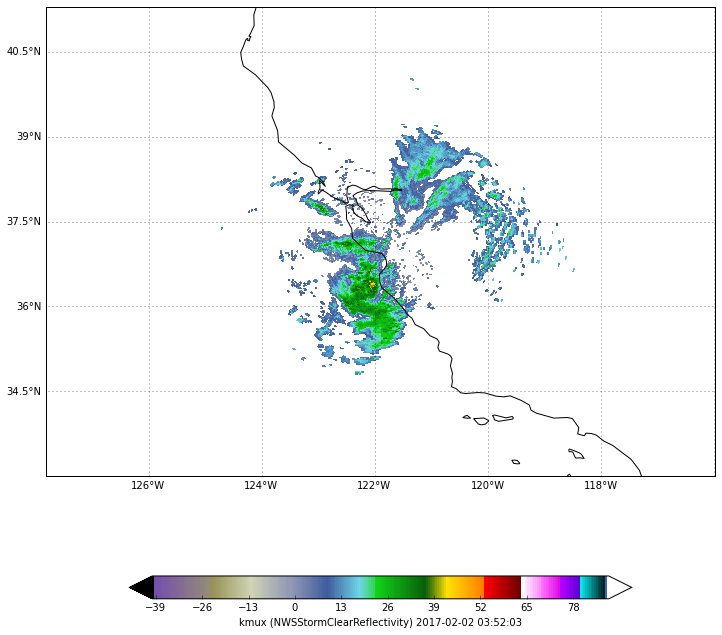

In [141]:
%matplotlib inline
from awips.dataaccess import DataAccessLayer
from awips import ThriftClient, RadarCommon
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
from dynamicserialize.dstypes.com.raytheon.uf.common.dataplugin.radar.request import GetRadarDataRecordRequest
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from metpy.plots import ctables
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pyproj import Geod

# set EDEX server and radar site definitions
edex = "edex-cloud.unidata.ucar.edu"
site = "kmux"
DataAccessLayer.changeEDEXHost(edex)
request = DataAccessLayer.newDataRequest()
request.setDatatype("radar")
request.setLocationNames(site)

# Get latest available time for site
datatimes = DataAccessLayer.getAvailableTimes(request)
timerange = datatimes[-1].validPeriod
dateTimeStr = str(datatimes[-1])
buffer = 60 # seconds
dateTime = datetime.strptime(dateTimeStr, "%Y-%m-%d %H:%M:%S")
beginRange = dateTime - timedelta(0, buffer)
endRange = dateTime + timedelta(0, buffer)
timerange = TimeRange(beginRange, endRange)

# Make request
client = ThriftClient.ThriftClient(edex)
request = GetRadarDataRecordRequest()
request.setTimeRange(timerange)
request.setRadarId(site)
request.setPrimaryElevationAngle("0.5")

# Define map config here
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(12, 12),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

# N0Q Reflectivity 
v = 94
ctable = 'NWSStormClearReflectivity'
rangeRes = 1000 # km
request.setProductCode(v)
response = client.sendRequest(request)

if response.getData():
    for record in response.getData():
        idra = record.getHdf5Data()
        rdat,azdat,depVals,threshVals = RadarCommon.get_hdf5_data(idra)
        dim = rdat.getDimension()
        radials,rangeGates = rdat.getSizes()
        dbzValues=np.array(rdat.getByteData())
        # 
        array = []
        for rec in dbzValues:
            if rec<0:
                rec+=256
            array.append(rec)        
        lat,lon = record.getLatitude(),record.getLongitude()
        if azdat :
            azVals = azdat.getFloatData()
            az = np.array(RadarCommon.encode_radial(azVals))
            dattyp = RadarCommon.get_data_type(azdat)
            az = np.append(az,az[-1])

        header = RadarCommon.get_header(record, format, rangeGates, radials, azdat, "description")
        rng = np.linspace(0, rangeGates, rangeGates + 1)
        
        # Convert az, range to a lat/lon
        g = Geod(ellps='clrk66')
        center_lat = np.ones([len(az),len(rng)])*float(lat)    
        center_lon = np.ones([len(az),len(rng)])*float(lon)
        az2D = np.ones_like(center_lat)*az[:,None]
        rng2D = np.ones_like(center_lat)*np.transpose(rng[:,None])*rangeRes
        llon,llat,back=g.fwd(center_lon,center_lat,az2D,rng2D)
        bbox = [llon.min(), llon.max(), llat.min(), llat.max()]

        multiArray = np.reshape(array, (-1, rangeGates))
        data = ma.array(multiArray)
        data = (data/2)-32.5
        data[data<=0] = ma.masked

        fig, ax = make_map(bbox=bbox)
        norm, cmap = ctables.registry.get_with_steps(ctable, -40, 0.5)
        cs = ax.pcolormesh(llon, llat, data, norm=norm, cmap=cmap)
        ax.set_aspect('equal', 'datalim')
        cbar = plt.colorbar(cs, extend='both', shrink=0.75, orientation='horizontal')
        cbar.set_label(site + " (" + ctable +  ") " + str(record.getDataTime()))
plt.show()

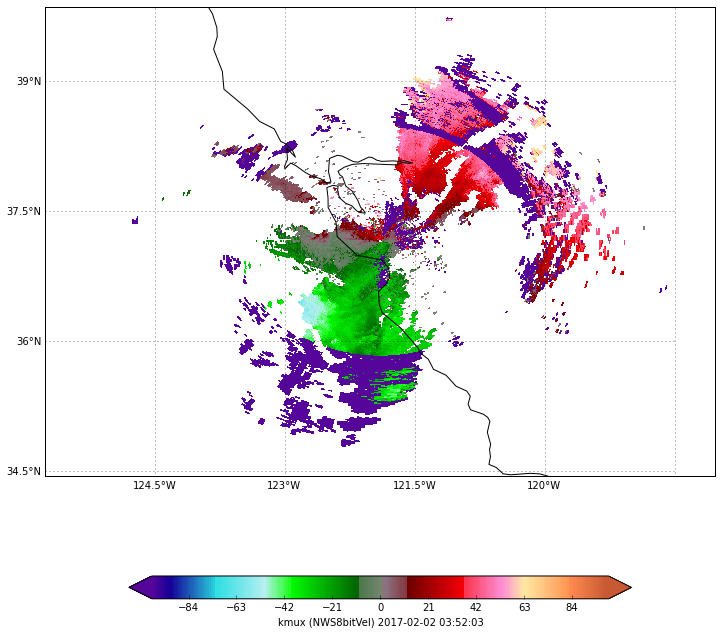

In [146]:
v = 99
ctable = 'NWS8bitVel'
rangeRes=250
request.setProductCode(v)
response = client.sendRequest(request)

if response.getData():
    for record in response.getData():
        idra = record.getHdf5Data()
        rdat,azdat,depVals,threshVals = RadarCommon.get_hdf5_data(idra)
        dim = rdat.getDimension()
        radials,rangeGates = rdat.getSizes()
        dValues=np.array(rdat.getByteData())
        # Need to convert byte data (-127 to 128) 
        array = []
        for rec in dValues:
            if rec<0:
                rec+=256
            array.append(rec)        
        lat,lon = record.getLatitude(),record.getLongitude()
        
        # get data for azimuth angles if we have them.
        if azdat :
            azVals = azdat.getFloatData()
            az = np.array(RadarCommon.encode_radial(azVals))
            dattyp = RadarCommon.get_data_type(azdat)
            az = np.append(az,az[-1])
        header = RadarCommon.get_header(record, format, rangeGates, radials, azdat, "description")
        rng = np.linspace(0, rangeGates, rangeGates + 1)

        # Convert az, range to a lat/lon
        g = Geod(ellps='clrk66')
        center_lat = np.ones([len(az),len(rng)])*float(lat)    
        center_lon = np.ones([len(az),len(rng)])*float(lon)
        az2D = np.ones_like(center_lat)*az[:,None]
        rng2D = np.ones_like(center_lat)*np.transpose(rng[:,None])*rangeRes
        llon,llat,back=g.fwd(center_lon,center_lat,az2D,rng2D)
        bbox = [llon.min(), llon.max(), llat.min(), llat.max()]
        multiArray = np.reshape(array, (-1, rangeGates))
        
        # threshVals[0:2] contains halfwords 31,32,33:
        # page 3-34: https://www.roc.noaa.gov/wsr88d/PublicDocs/ICDS/2620001U.pdf
        #  - halfword 31 contains the minimum data value in m/s*10
        #  - halfword 32 contains the increment in m/s*10
        #  - halfword 33 contains the number of levels (0 - 255)
        multiArray[multiArray==0] = ma.masked
        data = ma.array(threshVals[0]/10. + (multiArray)*threshVals[1]/10.)
        data[data<-63] = ma.masked
        data *= 1.94384 # Convert to knots

        fig, ax = make_map(bbox=bbox)
        norm, cmap = ctables.registry.get_with_steps(ctable, -100,1)
        cs = ax.pcolormesh(llon, llat, data, norm=norm, cmap=cmap)
        ax.set_aspect('equal', 'datalim')
        cbar = plt.colorbar(cs, extend='both', shrink=0.75, orientation='horizontal')
        cbar.set_label(site + " (" + ctable +  ") " + str(record.getDataTime()))

plt.show()

verified against AWIPS CAVE rendering

![http://i.imgur.com/FWwp1al.png](http://i.imgur.com/FWwp1al.png)